In [1]:
from random import randint, random
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
#define necessary classes and functions

class Car:
    current_node = None
    start_node = None
    end_node = None

    def __init__(self, current_node: str, start_node: str, end_node: str) -> None:
        self.current_node = current_node
        self.start_node = start_node
        self.end_node = end_node
        return
    
"""NOTE: the state passed to a function will be the cars dictionary"""

def genActions(graph: dict, state: dict) -> list: #generate actions
    actions = []
    ids = list(state.keys())
    for id in ids: #generates tuples of (id, edge) considering all traverable edges for a given car
        c = state[id]
        start_node = c.current_node
        neighbors = graph[start_node]
        for n in neighbors:
            action = (id, start_node + n)
            actions.append(action)
    return actions

def newState(action: tuple, state: dict) -> None: #move car to new node based on edge given in action
    id = action[0]
    new_node = action[1][1]
    car = state[id]
    car.current_node = new_node
    return

def stateKey(state: dict) -> tuple: #get a str(list) representing the state, used for keys in qtable
    list_rep = []
    keys = list(state.keys())
    for k in keys:
        car = state[k]
        tup_rep = (k, car.current_node)
        list_rep.append(tup_rep)
    return str(list_rep)

def congestion(state: dict) -> sum: #calculate congestion of a given state
    nodes = []
    sum_ = 0
    ids = list(state.keys())
    for id in ids: #sum_ is incremented everytime we detect a vehicle at an already occupied node
        c = state[id]
        current_node = c.current_node
        if current_node in nodes:
            sum_ += 1
        else:
            nodes.append(current_node)
    return sum_

def reward(action: tuple, prev_state: dict, new_state: dict, edges: dict) -> int: #calculate reward of a given state
    #calculate congestion of both states
    c1 = congestion(prev_state)
    c2 = congestion(new_state)

    #get edge weight
    edge = action[1]
    weight = edges[edge]

    #determine if car has reached its destination
    done = 0
    id = action[0]
    car = new_state[id]
    if car.current_node == car.end_node:
        done = 1
        new_state.pop(id)

    #calculate and return reward
    reward_ = c1 - c2 - weight + 100*done
    return reward_

def chooseAction(state: dict, actions: list, qtable: dict, iteration: int) -> tuple: #choose action using epsilon-greedy
    action = None
    epsilon = iteration/100 if iteration < 90 else 0.9
    value = random()
    if len(qtable) > 0 and value <= epsilon:
        keys = [(stateKey(state), a) for a in actions]
        max_key = keys[0]
        for k in keys:
            try:
                if qtable[k] > qtable[max_key]:
                    max_key = k
            except:
                pass
        s, action = max_key
    else:
        index = randint(0, len(actions)-1)
        action = actions[index]
    return action

def maxFutureReward(qtable: dict, graph: dict, new_state: dict) -> float: #return max future reward
    if len(qtable) == 0:
        return 0
    
    actions = genActions(graph, new_state)
    keys = [(stateKey(new_state), a) for a in actions]
    max_reward = qtable[min(qtable)]
    for key in keys:
        try:
            if qtable[key] > max_reward:
                max_reward = qtable[key]
        except:
            pass
    return max_reward

def updateQtable(qtable: dict, prev_state: dict, reward: int, max_future_reward: float, action: tuple) -> None: #update qtable(state, action)
    alpha = 0.1
    gamma = 0.9
    old_key = (stateKey(prev_state), action)

    try:
        qtable[old_key] = qtable[old_key] + alpha*((reward + gamma*max_future_reward) - qtable[old_key])
    except:
        qtable[old_key] = alpha*((reward + gamma*max_future_reward))
    
    return

In [4]:
#define necessary variables

car1 = Car('A', 'A', 'F')
car2 = Car('F', 'F', 'A')
car3 = Car('D', 'D', 'C')

cars = {
    1: car1,
    2: car2,
    3: car3
}

graph = {
    'A': ['B', 'D'],
    'B': ['A', 'C', 'E'],
    'C': ['B', 'F'],
    'D': ['A', 'E'],
    'E': ['D', 'B', 'F'],
    'F': ['E', 'C']
}

edges = {
    'AB': randint(1, 10),
    'AD': randint(1, 10),
    'BC': randint(1, 10),
    'BE': randint(1, 10),
    'CF': randint(1, 10),
    'DE': randint(1, 10),
    'EF': randint(1, 10),
}

qtable = {}

#add reverse edges
keys = list(edges.keys())
for k in keys:
    edges[k[::-1]] = edges[k]


In [5]:
#main q-learning algorithm

iterations = 1000
sums_rewards = []
for i in range(iterations):
    state = deepcopy(cars)
    sum_rewards = 0
    done = False
    num_keys = 0
    while not done:
        #generate and choose action
        actions = genActions(graph, state)
        action = chooseAction(state, actions, qtable, i)
        
        #update state
        prev_state = deepcopy(state)
        newState(action, state)
        new_state = deepcopy(state)

        #calculate reward
        reward_ = reward(action, prev_state, new_state, edges)
        sum_rewards += reward_
        state = new_state #reward function removes cars that have reached their destination, so we need to match new_state and state

        #update qtable
        max_future_reward = maxFutureReward(qtable, graph, new_state)
        updateQtable(qtable, prev_state, reward_, max_future_reward, action)

        if len(state) == 0:
            done = True

    sums_rewards.append(sum_rewards)

Text(0, 0.5, 'sum of rewards')

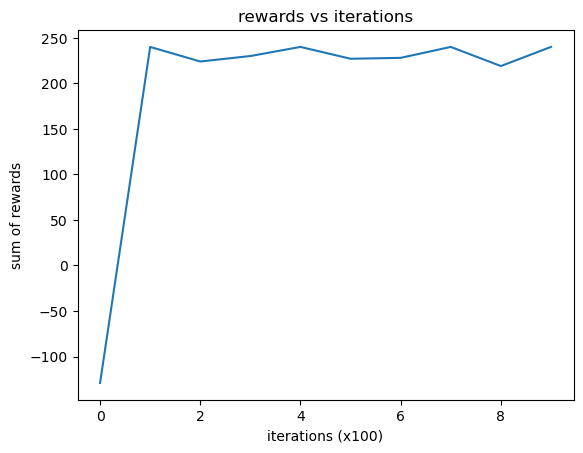

In [9]:
#output rewards graph

values = []
for i in range(len(sums_rewards)):
    if i % 100 == 0:
        values.append(sums_rewards[i])
        
plt.plot(values)
plt.title('rewards vs iterations')
plt.xlabel('iterations (x100)')
plt.ylabel('sum of rewards')